In [100]:
from matplotlib import pyplot as plt
import numpy as np

In [101]:
# Global variables from the constants table, all in GeV^-2.
M_z = 91.188
Gamma_z = 2.4414
alpha = 1 / 132.507
G_f = 1.16639 * 10e-5
W_angle_2 = 0.222246

Q_e = Q_mu = -1
V_e = V_mu = -0.5 + 2 * W_angle_2
A_e = A_mu = -0.5

kappa = np.sqrt(2) * G_f * M_z ** 2 / (4 * np.pi * alpha)

In [102]:
# Function for the differential cross section for center-of-mass energy and scattering angle.
def diff_cross_section(s_hat, theta):
    coeff = alpha ** 2 / (4 * s_hat)
    return coeff * (A_0(s_hat) * (1 + np.cos(theta) ** 2) + A_1(s_hat) * np.cos(theta))

def A_0(s_hat):
    return Q_e ** 2 - 2 * Q_e * V_mu * V_e * X_1(s_hat) + (A_mu ** 2 + V_mu ** 2) * (A_e ** 2 + V_e ** 2) * X_2(s_hat)

def A_1(s_hat):
    return -4 * Q_e * A_mu * A_e * X_1(s_hat) + 8 * A_mu * V_mu * A_e * V_e * X_2(s_hat)

def X_1(s_hat):
    return kappa * s_hat * (s_hat - M_z ** 2) / ((s_hat - M_z ** 2) ** 2 + Gamma_z ** 2 * M_z ** 2)

def X_2(s_hat):
    return kappa ** 2 * s_hat ** 2 / ((s_hat - M_z ** 2) ** 2 + Gamma_z ** 2 * M_z ** 2)

In [103]:
# My function to map uniform samples to the problem domain.
def map_to_domain(x, y):
    # E_cm = [10, 200] and cos(theta) = [-1, 1].
    s_hat = 10 + 190 * x
    cos_theta = -1 + 2 * y

    return (s_hat, np.arccos(cos_theta))

# VEGAS-plus includes grid sampling to reduce variance.
def adapt_grid(f_values, old_grid):
    f_values /= np.sum(f_values)
    cum_values = np.cumsum(f_values)
    cum_values = np.insert(cum_values, 0, 0)

    # Divide domain into regions based on the cumulative values.
    new_grid = np.interp(np.linspace(0, 1, len(old_grid)), cum_values, old_grid)
    return new_grid

In [104]:
# Parameters
bins = 100
iters = 100
samples = 10000

x_grid, y_grid = np.linspace(0, 1, bins + 1), np.linspace(0, 1, bins + 1)
estimations = []

for i in range(iters):
    sum_f, sum_f2 = np.zeros((bins, bins)), np.zeros((bins, bins))
    estimation = 0

    for _ in range(samples):
        # Sampling random positions.
        xi = np.random.randint(bins)
        yi = np.random.randint(bins)
        x = np.random.uniform(x_grid[xi], x_grid[xi + 1])
        y = np.random.uniform(y_grid[yi], y_grid[yi + 1])

        # Map the position to acceptable s and theta.
        s_hat, theta = map_to_domain(x, y)
        f = diff_cross_section(s_hat, theta)

        # Add the estimated integral along with the grid location for adaptive sampling.
        estimation += f
        sum_f[xi, yi] += f
        sum_f2[xi, yi] += f ** 2

    estimation /= samples
    estimations.append(estimation)
    if i % 10 == 0:
        print(f"Iteration {i + 1}, Integral Estimate: {estimation}")

    # In plus version, we update the grid position with an grid adaptation method.
    sum_f /= np.sum(sum_f)
    x_grid = adapt_grid(np.sum(sum_f, axis=1), x_grid)
    y_grid = adapt_grid(np.sum(sum_f, axis=0), y_grid)

Iteration 1, Integral Estimate: 3.000922979153105e-07
Iteration 11, Integral Estimate: 2.31366220676603e-06
Iteration 21, Integral Estimate: 2.5690427352725384e-06
Iteration 31, Integral Estimate: 2.6573913560292706e-06
Iteration 41, Integral Estimate: 2.7094079899887745e-06
Iteration 51, Integral Estimate: 2.7334792458845342e-06
Iteration 61, Integral Estimate: 2.7642312496261694e-06
Iteration 71, Integral Estimate: 2.7683425322163885e-06
Iteration 81, Integral Estimate: 2.7755770049002594e-06
Iteration 91, Integral Estimate: 2.788843759233797e-06


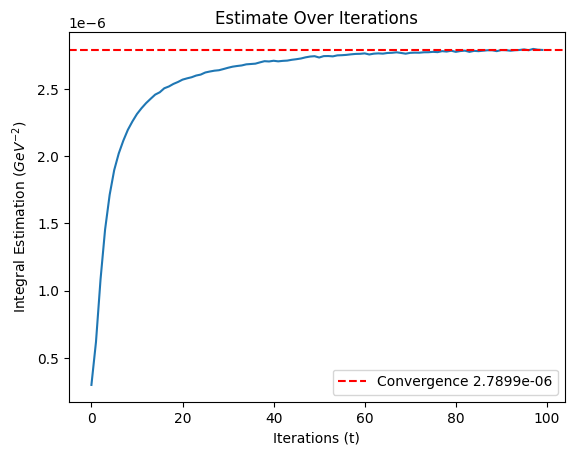

In [105]:
plt.plot(np.arange(iters), estimations)
plt.xlabel(r'Iterations (t)')
plt.ylabel(r'Integral Estimation $(GeV^{-2})$')
plt.title('Estimate Over Iterations')
plt.axhline(y=estimations[-1], color='r', linestyle='--', label=f'Convergence {round(estimations[-1], 10)}')
plt.legend()
plt.show()